In [2]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.stats as stats 

In [3]:
'''
Geographic Weighted Regression Model for Leukemia in Floria Counties applying pysal GWR libraries
Dependent Variable: Leukemia Incidence per 100,000 people
Independent Variables:
obs_pct : percent of population that is obese 2019 FL Health Survey
Percent_sm: percent of adult populations who are smokers 2019 FL Health Survey
PCT_ATRISK: Percent of populations between 0-15 and 65+
pesticide_: Percent of land cover per county with probable pesticide use
hydro_pct: Percent of land cover per county of hydrocarbon and other power infrastructure
uploading to github for convenient jupyter notebook output support
'''
fl_counties = gp.read_file('E:\\fl_leuk\\leukemia_fl.shp')
'''filtering zero incidence counties'''
fl_counties = fl_counties.loc[fl_counties['INCIDENCE_'] > 0].copy()
fl_counties = fl_counties.loc[fl_counties['FIPS'] != '125'].copy()

fl_y = fl_counties['INCIDENCE_'].values.reshape((-1,1)) #leukemia incidence per 100,000
#p value for pesticides variable was too high, its being taken out
fl_x = fl_counties[["obs_pct", "Percent_sm", "PCT_ATRISK", "hydro_pct"]].values 

coord_x = fl_counties['cen_x']
coord_y = fl_counties['cen_y']
centroid_coords = list(zip(coord_x,coord_y))
#normalize independent variables
fl_x = (fl_x - fl_x.mean(axis=0)) / fl_x.std(axis=0)
fl_y = fl_y.reshape((-1,1))
fl_y = (fl_y- fl_y.mean(axis=0)) / fl_y.std(axis=0)
fl_counties.head()


,NAME,FIPS,INCIDENCE_,AVG_ANNUAL,cen_x,cen_y,COUNTY,POPESTIMAT,area_sq_km,ppl_per_sq,obs_pct,Percent_sm,PCT_ATRISK,pesticide_,hydro_pct,geometry
0,Brevard,009,21.1,196,-8.987088e+06,3.286203e+06,009,643979,4341.836676,148,30.7,16.3,38.33,12.79,12.84,"POLYGON ((-9.02e+06 3.33e+06, -9.02e+06 3.33e+..."
1,Columbia,023,17.7,17,-9.197380e+06,3.532487e+06,023,73063,2789.144396,26,35.2,23.9,37.41,8.77,4.53,"POLYGON ((-9.22e+06 3.5e+06, -9.22e+06 3.5e+06..."
2,Gadsden,039,14.1,9,-9.419146e+06,3.578267e+06,039,43833,1853.111565,24,48.1,15.1,36.98,4.74,13.26,"POLYGON ((-9.45e+06 3.58e+06, -9.45e+06 3.58e+..."
3,Highlands,055,14.9,30,-9.054843e+06,3.166474e+06,055,107614,3645.974628,30,29.1,16.5,48.61,37.84,16.96,"POLYGON ((-9.08e+06 3.17e+06, -9.08e+06 3.18e+..."
5,Leon,073,14.9,44,-9.381763e+06,3.562588e+06,073,296913,2454.205165,121,27.5,14.3,29.18,2.24,12.77,"POLYGON ((-9.43e+06 3.55e+06, -9.43e+06 3.55e+..."


In [4]:
gwr_selector = Sel_BW(centroid_coords, fl_y, fl_x)
gwr_bw = gwr_selector.search(multi_bw_min=[2])
print(gwr_bw)
gwr_results = GWR(centroid_coords, fl_y, fl_x, gwr_bw).fit()

58.0


In [5]:
np.float = float #fix for deprecated numpy float issue
'''gwr results with all 5 variables'''
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  59
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             41.311
Log-likelihood:                                                     -73.203
AIC:                                                                156.407
AICc:                                                               160.022
BIC:                                                               -178.876
R2:                                                                   0.300
Adj. R2:                                                              0.248

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

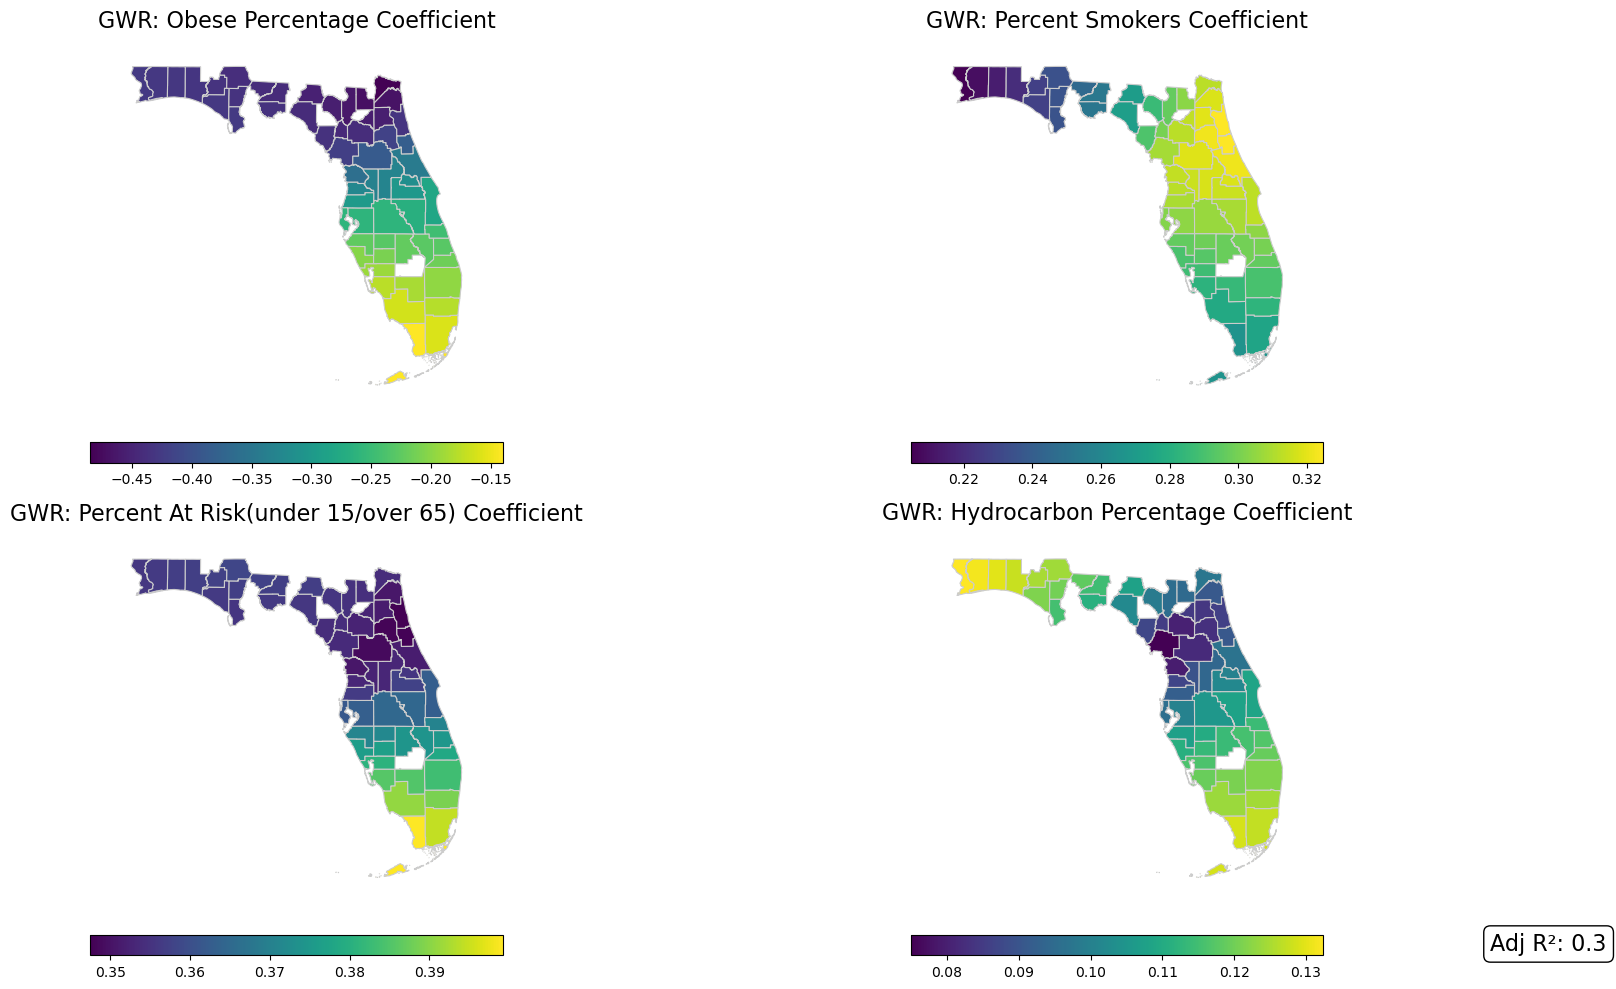

<Figure size 640x480 with 0 Axes>

In [6]:
# Coefficients
fl_counties['co_intercept'] = gwr_results.params[:, 0]
fl_counties['co_obs_pct'] = gwr_results.params[:, 1]
fl_counties['co_percent_smokers'] = gwr_results.params[:, 2]
fl_counties['co_pct_atrisk'] = gwr_results.params[:, 3]
fl_counties['co_hydro_pct'] = gwr_results.params[:, 4]
fl_counties['residuals'] = gwr_results.std_res
fl_counties['local_r2'] = gwr_results.localR2

variables = [
    ('co_obs_pct', 'GWR: Obese Percentage Coefficient'),                          #X1
    ('co_percent_smokers', 'GWR: Percent Smokers Coefficient'),                   #X2
    ('co_pct_atrisk', 'GWR: Percent At Risk(under 15/over 65) Coefficient'),      #X3
    ('co_hydro_pct', 'GWR: Hydrocarbon Percentage Coefficient')                   #X4
]
num_vars = len(variables)
num_cols = 2
num_rows = (num_vars + 1) // 2  # Ceiling division to ensure enough rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))
axes = axes.flatten()

for i, (col, title) in enumerate(variables):
    ax = axes[i]
    ax.set_title(title, fontsize=16)
    cmap = plt.cm.viridis
    vmin = fl_counties[col].min()
    vmax = fl_counties[col].max()
    fl_counties.plot(column=col, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)
    ax.set_axis_off()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.text(0.95, 0.05, 'Adj R²: 0.3', fontsize=16, ha='right', va='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

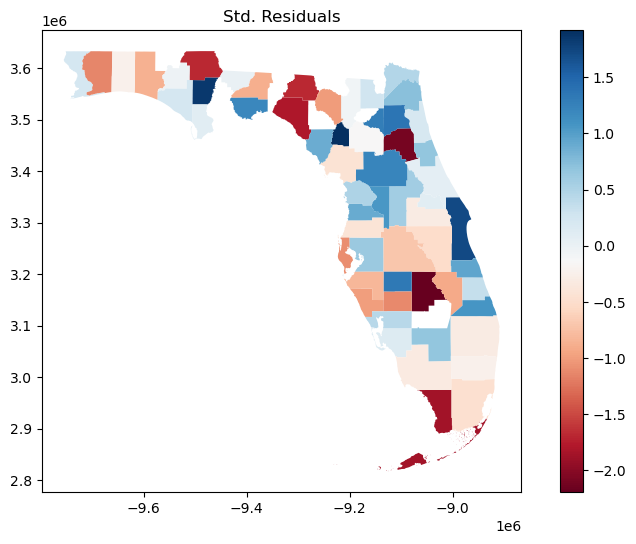

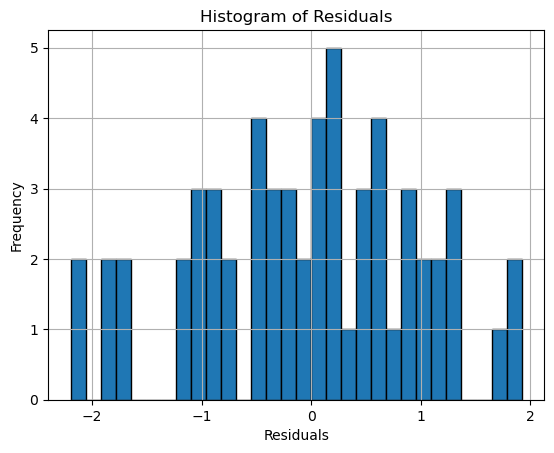

In [7]:
fl_counties.plot(column='residuals', cmap='RdBu', legend=True, figsize=(10, 6))
plt.title('Std. Residuals')
plt.show()
fl_counties['residuals'].hist(bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

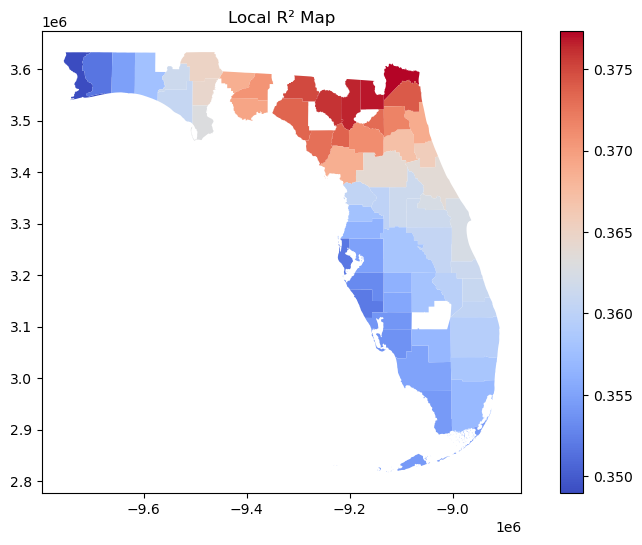

In [8]:
fl_counties.plot(column='local_r2', cmap='coolwarm', legend=True, figsize=(10, 6))
plt.title('Local R² Map')
plt.show()

In [ ]:
#Residual Sum of Squares (RSS): Quantify the total error in the model.
rss = np.sum(gwr_results.resid_response ** 2)
print(f"Residual Sum of Squares (RSS): {rss:.2f}")
fl_counties.to_file("E:\\fl_leuk\\scripts\\output_shp\\fl_leukemia_gwr.shp")

Residual Sum of Squares (RSS): 37.64


C:\Users\Andy\AppData\Local\Temp\ipykernel_13332\682175299.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fl_counties.to_file("fl_leukemia_gwr.shp")
d:\Users\Andy\miniconda3\envs\my_env\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'co_intercept' to 'co_interce'
  ogr_write(
d:\Users\Andy\miniconda3\envs\my_env\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'co_percent_smokers' to 'co_percent'
  ogr_write(
d:\Users\Andy\miniconda3\envs\my_env\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'co_pct_atrisk' to 'co_pct_atr'
  ogr_write(
d:\Users\Andy\miniconda3\envs\my_env\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'co_hydro_pct' to 'co_hydro_p'
  ogr_write(
